## Part 1:

Gather the dataset of hubNashville requests from https://data.nashville.gov/Public-Services/hubNashville-311-Service-Requests/7qhx-rexh. For this project, you should look at requests with Request Type of "COVID-19" and Subrequest Type of "COVID-19 Violations". Explore this dataset, looking at when and where these violations occurred.



In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
#getting data from API, case_requests = COVID-19 and setting limit to 25k

url = 'https://data.nashville.gov/resource/7qhx-rexh.json?case_request=COVID-19&$limit=25000'

response = requests.get(url)

In [3]:
#reading the json text to dataframe

hubNashville = pd.read_json(response.text)

In [4]:
#subsetting for case_requests and case_subrequest

hubNashville = hubNashville[hubNashville['case_subrequest'] == 'COVID-19 Violations']

In [5]:
#assigning unnecessary columns
cols = ['case_request', 'case_subrequest', 'additional_subrequest', 'state_issue', 'closed_when_created', 'contact_type','parent_case', 'status', 'date_time_closed', 'case_origin', 'incident_council_district', 'mapped_location']

#dropping unnecessary columns
hubNashville = hubNashville.drop(columns=cols, axis=1)

In [6]:
#converting open to datetime
hubNashville['date_time_opened'] = [pd.to_datetime(d) for d in hubNashville['date_time_opened']]

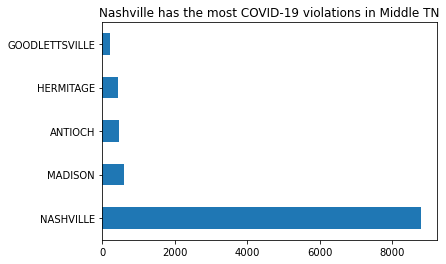

In [82]:
hubNashville['incident_city'].value_counts().head().plot(kind='barh', 
                                                  title='Nashville has the most COVID-19 violations in Middle TN')
plt.savefig('../violation_city.png', dpi=100, facecolor='w', edgecolor='w', bbox_inches='tight' ,pad_inches=1);

Nashville leads the number of violations with 8798

In [8]:
#creating new column with value_counts
hubNashville['opened_year_month_date'] = hubNashville['date_time_opened'].dt.strftime('%Y-%m-%d')

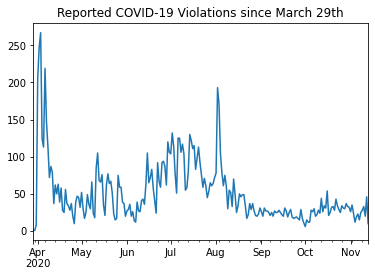

In [83]:
hubNashville['opened_year_month_date'].value_counts().sort_index().plot(title='Reported COVID-19 Violations since March 29th')
plt.savefig('../violations_since_march.png', dpi=100, facecolor='w', edgecolor='w', bbox_inches='tight');

In [10]:
#reading zipcode data
zipcodes = gpd.read_file('../data/nashzipcodes.geojson')

In [11]:
#creating geometry column for plotting with geopandas
hubNashville['geometry'] = hubNashville.apply(lambda x: Point((float(x.longitude),
                                                               float(x.latitude))),
                                              axis=1)

In [12]:
# create geodataframe of hubNashville
hubNashville_geo = gpd.GeoDataFrame(hubNashville, 
                           crs = zipcodes.crs, 
                           geometry = hubNashville['geometry'])

In [13]:
#dropping duplicates so plotting will work
hubNashville_geo = hubNashville_geo.dropna()

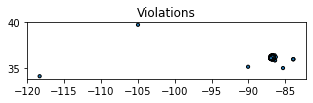

In [14]:
ax = zipcodes.plot(figsize = (5, 5), color = 'white', edgecolor = 'lightgrey')

plt.scatter(x=hubNashville_geo['longitude'], y=hubNashville_geo['latitude'], 
               sizes=(10,10), edgecolor = 'black')
plt.title('Violations');

## Part 2:
The file davidson_cases.csv contains the number of COVID cases in Davidson county per day from March 8 through October 29. Use this dataset to compare the trend for the number of cases over time to the number of reported violations. Feel free to add any additional data that you think might be useful.

In [15]:
davidsonco_cases = pd.read_csv('../data/davidson_cases.csv')

In [16]:
#converting date to datetime and setting as index
davidsonco_cases['date'] = pd.to_datetime(davidsonco_cases['date'])
davidsonco_cases = davidsonco_cases.set_index('date')
davidsonco_cases = davidsonco_cases.sort_index()

In [17]:
hubNashville['opened_year_month_date'] = pd.to_datetime(hubNashville['opened_year_month_date'])

In [18]:
violations_per_day = hubNashville['opened_year_month_date'].value_counts().to_frame()
violations_per_day = violations_per_day.sort_index()
violations_per_day = violations_per_day.rename(columns={'opened_year_month_date':'count'})

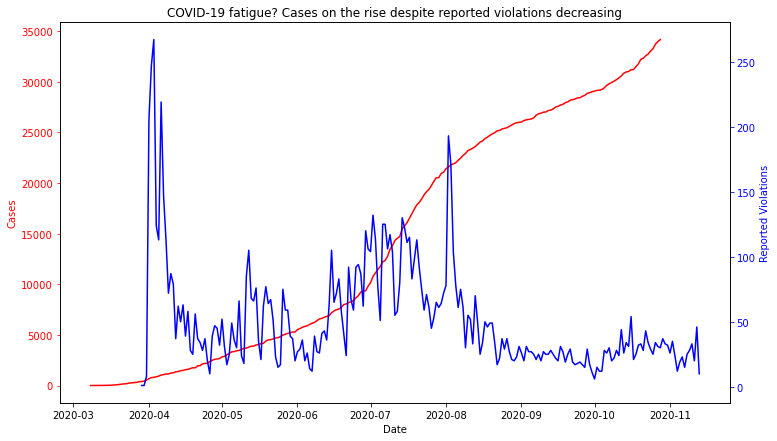

In [86]:
#plot
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(davidsonco_cases.index, davidsonco_cases['cases'], 
           color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Cases', color='red')
ax.tick_params('y', colors='red')
ax2 = ax.twinx()
ax2.plot(violations_per_day.index, violations_per_day['count'],          
         color='blue')
ax2.set_ylabel('Reported Violations', color='blue')
ax2.tick_params('y', colors='blue')
plt.title('COVID-19 fatigue? Cases on the rise despite reported violations decreasing')
plt.savefig('../cases_and_violations.png', dpi=100, facecolor='w', edgecolor='w', bbox_inches='tight');

## Part 3:
The Metro Public Health Department tracks COVID-19 clusters. The files clusters.csv and clusters_by_type.csv contain the tables of clusters as reported by WSMV along with the coordinates of the clusters. Can you find any connection between the reported COVID violations and subsequent COVID clusters?

In [20]:
clusters = pd.read_csv('../data/clusters_revised.csv')

In [37]:
#creating geometry column
clusters['geometry'] = clusters.apply(lambda x: Point((float(x.Longitude), 
                                                         float(x.Latitude))), 
                                        axis=1)

In [22]:
clusters = clusters.dropna()

In [23]:
#geodataframe for clusters data
clusters_geo = gpd.GeoDataFrame(clusters, 
                           crs = zipcodes.crs, 
                           geometry = clusters['geometry'])

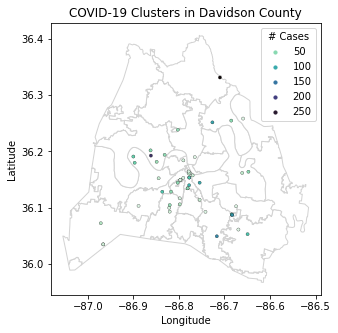

In [24]:
ax = zipcodes.plot(figsize = (5, 5), color = 'white', edgecolor = 'lightgray')

sns.scatterplot(data=clusters, x="Longitude", y="Latitude", hue="# Cases", palette="mako_r", size="# Cases", sizes=(10, 10), edgecolor = 'black')
plt.title('COVID-19 Clusters in Davidson County');

In [25]:
#merging violations and clusters on lat/long to get business names
#violations_clusters = pd.merge(hubNashville, clusters, left_on=['latitude', 'longitude'],
                              #right_on=['Latitude', 'Longitude'])

In [26]:
#assigning unnecessary columns
#cols = ['Latitude', 'Longitude', 'geometry_y']

#dropping unnecessary columns
#violations_clusters = violations_clusters.drop(columns=cols, axis=1)

## Part 4:
The dataset from data.nashville.gov includes geospatial information, which allows you to see where violations occurred geographically, but it does not provide information in regard to the specific businesses that were reported. In this part, you should explore the businesses and types of businesses that have been reported. To attempt to answer this, you have been provided data from the Google Places API.

In [27]:
import glob
from pandas.io.json import json_normalize

In [28]:
google_results = pd.DataFrame() #create empty dataframe
for filename in glob.glob('../data/google_places_results/*.json'): # loop through .json files
    with open(filename) as f:
        google_files = json.load(f) # open the json file
        google_jsons = pd.json_normalize(google_files, sep='_', #normalize the json file for nested results
                            record_path='results')
        google_results = google_results.append(google_jsons) #append each json file results to dataframe

In [87]:
google_results.columns

Index(['name', 'types', 'google_address', 'latitude', 'longitude'], dtype='object')

In [30]:
#selecting only the columns we want
google_results = google_results[['name', 'types', 'vicinity', 'geometry_location_lat', 'geometry_location_lng']].reset_index(drop=True)

In [31]:
#renaming columns in preparation for merge
google_results = google_results.rename(columns={'vicinity': 'google_address', 
                               'geometry_location_lat': 'latitude',
                               'geometry_location_lng': 'longitude'})

In [32]:
#merging hubNashville with google_results
violations_google_results = hubNashville.merge(google_results, on=['latitude', 'longitude'])

In [33]:
#removing duplicates that have the same date_time_opened, latitude, and long
violations_google_results = violations_google_results.drop_duplicates(subset=['date_time_opened','latitude', 'longitude']).reset_index(drop=True)

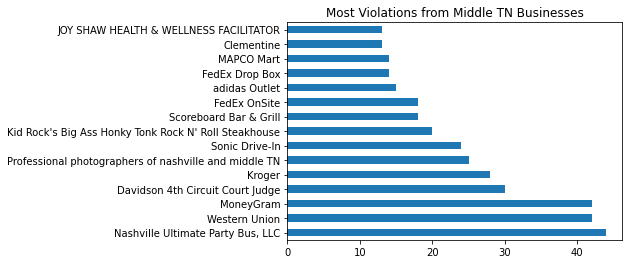

In [60]:
violations_google_results['name'].value_counts().head(15).plot(kind='barh',
                                                              title='Most Violations from Middle TN Businesses');

In [36]:
violations_google_results['name'].value_counts().describe()

count    1115.000000
mean        2.159641
std         3.304910
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        44.000000
Name: name, dtype: float64

In [90]:
violations_google_results['name'].value_counts()

Nashville Ultimate Party Bus, LLC    44
Western Union                        42
MoneyGram                            42
Davidson 4th Circuit Court Judge     30
Kroger                               28
                                     ..
Raceway                               1
Fine Salon & Dry Bar                  1
Biscuit Love (Hillsboro Village)      1
Herbalife Joanna'S Nutrition          1
Sun & Ski Sports                      1
Name: name, Length: 1115, dtype: int64